In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import io
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import (Dataset, DataLoader)

#### Draw
from torchviz import make_dot
from torchsummary import summary

from IPython.display import display, HTML

In [3]:
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

In [4]:
torch.backends.cudnn.enabled = True
torch.manual_seed(8888);

## 准备数据集

In [18]:
n_samples = 25
data_root = '/data/datasets/torchvision/'

def unnormlize():
    pass

trans = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(data_root, train=True, transform=trans)
len(train_dataset)

60000

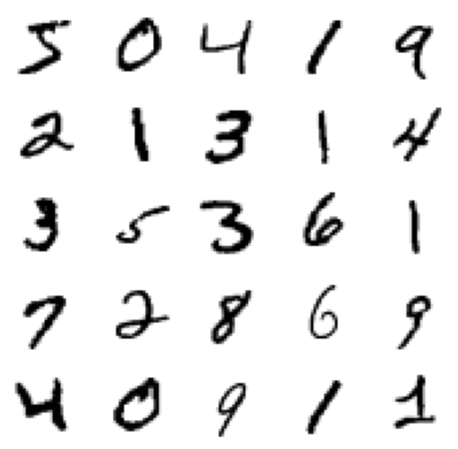

In [6]:
plt.figure(figsize=(8, 8))
for i in range(n_samples):
    img = train_dataset[i][0]
    img = img * 0.5 + 0.5 # Denormalize
    img = transforms.ToPILImage()(img)
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')
plt.show()

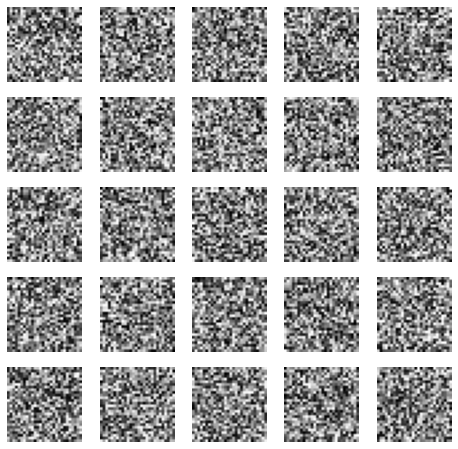

In [7]:
# random fake image generated by uniform distribution.
plt.figure(figsize=(8, 8))
for i in range(n_samples):
    img = transforms.ToPILImage()(torch.randn_like(train_dataset[0][0]))
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='gray_r')
plt.show()

## 辨别器模型

In [19]:
class Discriminator(nn.Module):
    def __init__(self, in_shapes=(1, 1, 28, 28)):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_shapes[1], 64, 3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.4),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout2d(p=0.4),
            nn.Flatten(),
            nn.Linear(64*(in_shapes[2] // 4)*(in_shapes[3] // 4), 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.model(x)
    
in_shapes = (1, 1, 28, 28)
modelD = Discriminator(in_shapes)

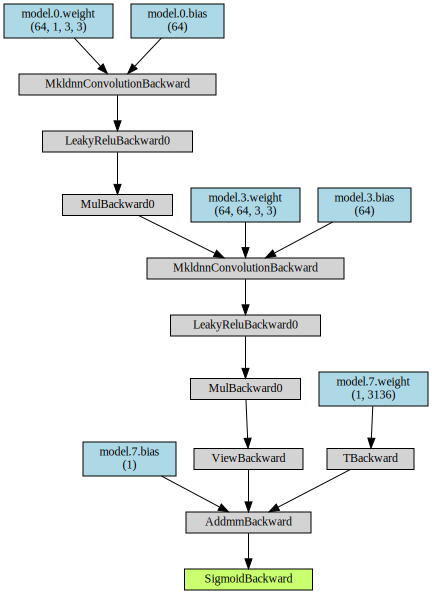

In [9]:
inputs = torch.zeros(*in_shapes, dtype=torch.float, requires_grad=False)
make_dot(modelD(inputs), params=dict(modelD.named_parameters()))

In [10]:
summary(modelD, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]             640
         LeakyReLU-2           [-1, 64, 14, 14]               0
         Dropout2d-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                    [-1, 1]           3,137
           Sigmoid-9                    [-1, 1]               0
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
---------------------------------------------

In [11]:
## 测试

num_epochs = 1
print_freq = 10
lr = 0.0002

dataloader = DataLoader(train_dataset, batch_size=64, num_workers=4)

d_optimizer = optim.Adam(modelD.parameters(), lr)

d_criterion = nn.BCELoss()

modelD.cuda()
modelD.train()

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(dataloader):
        real_image = image.to('cuda')
        real_label = torch.ones_like(label.unsqueeze(dim=1), dtype=torch.float, device='cuda')
        fake_image = torch.randn_like(real_image)
        fake_label = torch.zeros_like(real_label)
        x = torch.cat([real_image, fake_image], dim=0)
        y = torch.cat([real_label, fake_label], dim=0)
        d_optimizer.zero_grad()
        y_hat = modelD(x)
        d_loss = d_criterion(y_hat, y)
        d_loss.backward()
        d_optimizer.step()
        
        if i % print_freq == 0:
            acc = (y_hat.detach() > 0.5).eq(y).sum().cpu().numpy() / (2 * image.shape[0])
            print("iter:", i, "acc:", acc, "loss:", d_loss.item())
            if acc >= 1.0:
                break

iter: 0 acc: 0.3671875 loss: 0.7104383707046509
iter: 10 acc: 0.953125 loss: 0.4649809002876282
iter: 20 acc: 1.0 loss: 0.23829244077205658


## 生成器模型

In [20]:
class nn_Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU(),
            nn_Reshape(-1, 256, 7, 7),
            nn.Conv2d(256, 128, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)
    
latent_dim = 100
modelG = Generator(latent_dim)

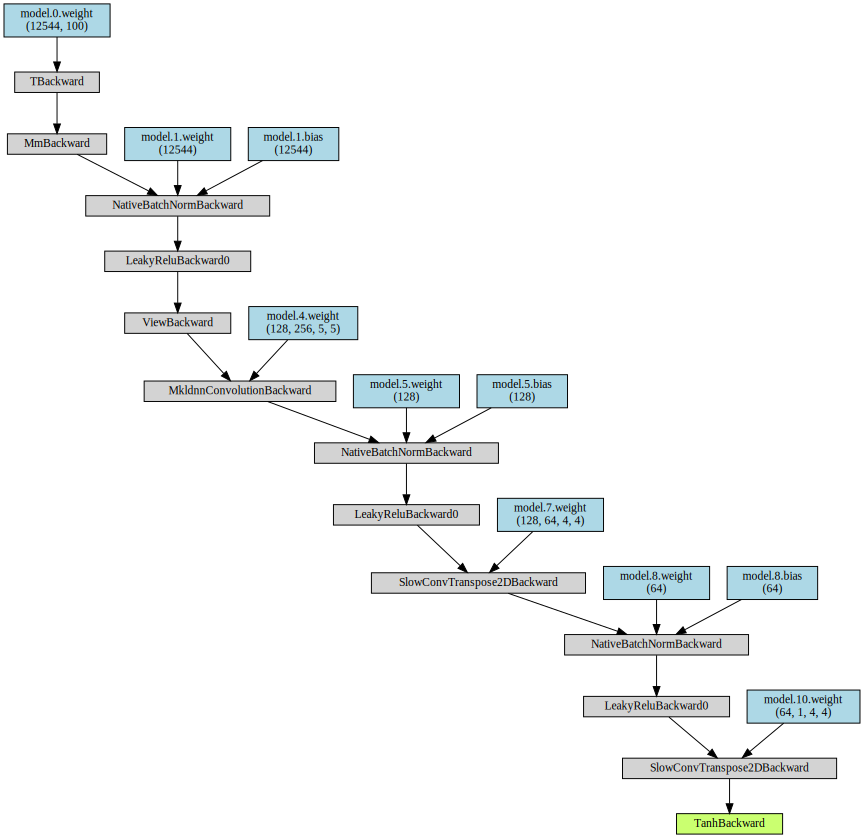

In [13]:
inputs = torch.randn(2, latent_dim, dtype=torch.float, requires_grad=False)
make_dot(modelG(inputs), params=dict(modelG.named_parameters()))

In [14]:
summary(modelG, input_size=(100,), batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 12544]       1,254,400
       BatchNorm1d-2                [-1, 12544]          25,088
         LeakyReLU-3                [-1, 12544]               0
        nn_Reshape-4            [-1, 256, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]         819,200
       BatchNorm2d-6            [-1, 128, 7, 7]             256
         LeakyReLU-7            [-1, 128, 7, 7]               0
   ConvTranspose2d-8           [-1, 64, 14, 14]         131,072
       BatchNorm2d-9           [-1, 64, 14, 14]             128
        LeakyReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11            [-1, 1, 28, 28]           1,024
             Tanh-12            [-1, 1, 28, 28]               0
Total params: 2,231,168
Trainable params: 2,231,168
Non-trainable params: 0
---------------------------

## 训练

In [16]:
def set_requires_grad(net, requires_grad=False):
    for param in net.parameters():
        param.requires_grad = requires_grad

In [ ]:
num_epochs = 50
print_freq = 50

d_lr = 0.0001
g_lr = 0.0002

dataloader = DataLoader(train_dataset, batch_size=512, num_workers=4)

d_optimizer = optim.Adam(modelD.parameters(), d_lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(modelG.parameters(), g_lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

modelD.cuda().train()
modelG.cuda().train()

g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (image, label) in enumerate(dataloader):
        real_image = image.to('cuda')
        real_label = torch.ones_like(label.unsqueeze(dim=1), dtype=torch.float, device='cuda')
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        
        ########### train discriminator model ###########
        set_requires_grad(modelD, True)
        with torch.no_grad():
            latent = torch.rand(image.shape[0], latent_dim, dtype=torch.float)
            fake_image = modelG(latent.to('cuda'))
            fake_label = torch.zeros_like(real_label)
            x = torch.cat([real_image, fake_image], dim=0)
            y = torch.cat([real_label, fake_label], dim=0)
        y_hat = modelD(x)
        d_loss = d_criterion(y_hat, y)
        d_loss.backward()
        d_optimizer.step()
        
        ########### train generator model (frozen D network) ###########
        set_requires_grad(modelD, False)
        latent = torch.rand(image.shape[0], latent_dim, dtype=torch.float)
        fake_image = modelG(latent.to('cuda'))
        fake_label = modelD(fake_image)
        g_loss = criterion(fake_label, torch.ones_like(fake_label))
        g_loss.backward()
        g_optimizer.step()
        
        if i % print_freq == 0:
            acc = (y_hat.detach() > 0.5).eq(y).sum().cpu().numpy() / (2 * image.shape[0])
            dls = d_loss.item()
            gls = g_loss.item()
            d_losses.append(dls)
            g_losses.append(gls)
            print("epoch:", epoch, "batchIdx:", i, "acc:", acc, "d_loss:", dls, "g_loss:", gls)
torch.save(modelD.state_dict(), '/data/D.pth')
torch.save(modelG.state_dict(), '/data/G.pth')

epoch: 0 batchIdx: 0 acc: 0.6396484375 d_loss: 0.6288504600524902 g_loss: 0.9332969784736633
epoch: 0 batchIdx: 50 acc: 0.95703125 d_loss: 0.4966456890106201 g_loss: 1.088060736656189
epoch: 0 batchIdx: 100 acc: 0.830078125 d_loss: 0.5929995179176331 g_loss: 0.8450005054473877
epoch: 1 batchIdx: 0 acc: 0.884765625 d_loss: 0.5638366341590881 g_loss: 0.8689645528793335
epoch: 1 batchIdx: 50 acc: 0.6552734375 d_loss: 0.6461849212646484 g_loss: 0.7600270509719849
epoch: 1 batchIdx: 100 acc: 0.763671875 d_loss: 0.6082035303115845 g_loss: 0.8199372887611389
epoch: 2 batchIdx: 0 acc: 0.759765625 d_loss: 0.5982162356376648 g_loss: 0.9086834192276001
epoch: 2 batchIdx: 50 acc: 0.791015625 d_loss: 0.5905529260635376 g_loss: 0.8648529052734375
epoch: 2 batchIdx: 100 acc: 0.8173828125 d_loss: 0.5551502704620361 g_loss: 0.9268907308578491
epoch: 3 batchIdx: 0 acc: 0.798828125 d_loss: 0.5650503039360046 g_loss: 0.8868728280067444
epoch: 3 batchIdx: 50 acc: 0.8212890625 d_loss: 0.5348049402236938 g_l

epoch: 29 batchIdx: 50 acc: 0.93359375 d_loss: 0.2588009238243103 g_loss: 2.176135540008545
epoch: 29 batchIdx: 100 acc: 0.9404296875 d_loss: 0.22750216722488403 g_loss: 1.9208537340164185
epoch: 30 batchIdx: 0 acc: 0.9462890625 d_loss: 0.23918864130973816 g_loss: 2.1637072563171387
epoch: 30 batchIdx: 50 acc: 0.8740234375 d_loss: 0.32794225215911865 g_loss: 1.771620750427246
epoch: 30 batchIdx: 100 acc: 0.890625 d_loss: 0.3071436285972595 g_loss: 1.742495059967041
epoch: 31 batchIdx: 0 acc: 0.9521484375 d_loss: 0.2020670771598816 g_loss: 3.0251622200012207
epoch: 31 batchIdx: 50 acc: 0.8447265625 d_loss: 0.3680041432380676 g_loss: 1.6695339679718018
epoch: 31 batchIdx: 100 acc: 0.931640625 d_loss: 0.23691344261169434 g_loss: 2.222111225128174
epoch: 32 batchIdx: 0 acc: 0.955078125 d_loss: 0.20341384410858154 g_loss: 2.330930709838867
epoch: 32 batchIdx: 50 acc: 0.927734375 d_loss: 0.27313295006752014 g_loss: 1.9892362356185913
epoch: 32 batchIdx: 100 acc: 0.9423828125 d_loss: 0.215455

In [ ]:
modelG.eval()
plt.figure(figsize=(3,3))
plt.axis('off')
with torch.no_grad():
    latent = torch.randn(1, latent_dim, dtype=torch.float)
    fake_image = modelG(latent.to('cuda'))
    fake_image = fake_image * 0.5 + 0.5
    plt.imshow(transforms.ToPILImage()(fake_image[0].cpu()), cmap='gray_r')

## References

- https://medium.com/intel-student-ambassadors/mnist-gan-detailed-step-by-step-explanation-implementation-in-code-ecc93b22dc60

- https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/

- https://github.com/ConorLazarou/pytorch-generative-models/blob/master/GAN/DCGAN/dcgan_mnist.py